In [27]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import string
import re
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.target import ClassBalance

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Importando dataset

In [29]:
tweets= pd.read_csv('tweets.csv', encoding='utf-8')
tweets.head()

,Text,Classificacao
0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,��� https://t.co/BnDsO34qK0,Neutro
4,��� PSOL vai questionar aumento de vereadores ...,Negativo


#### Mudando as classes 'Positivo' para 1 e 'Negativo' para 0, e espalhando aleatóriamente a classe 'Neutro'

In [30]:
for i, v in tweets.Classificacao.items():
    if v == 'Positivo':
        tweets.Classificacao.values[i] = 1
    elif v == 'Negativo':
        tweets.Classificacao.values[i] = 0
    else:
        tweets.Classificacao.values[i] = np.random.choice([0, 1])

tweets.Classificacao = tweets.Classificacao.map({0 : 'Negativo', 1: 'Positivo'})
tweets.Classificacao.value_counts()

Positivo    4492
Negativo    3707
Name: Classificacao, dtype: int64

#### Verificando informações dos dados

In [31]:
tweets.describe()

,Text,Classificacao
count,8199,8199
unique,5765,2
top,RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara...,Positivo
freq,300,4492


In [32]:
tweets.groupby('Classificacao').describe()

Text                                                            \
              count unique                                                top   
Classificacao                                                                   
Negativo       3707   1994  RT @AnaPaulaVolei: Mais 2 helicópteros!!A cara...   
Positivo       4492   3844  RT @JornalOGlobo: Com três anos, presídio priv...   

                    
              freq  
Classificacao       
Negativo       300  
Positivo        74

In [33]:
#podemos perceber muitos duplicados, vamos dropa-los
print('Quantidade de tweets antes do drop: ', len(tweets.Text),
      '\nQuantidade de tweets depois do drop: ', len(tweets.drop_duplicates(['Text'])))

tweets = tweets.drop_duplicates(['Text'])

Quantidade de tweets antes do drop:  8199 
Quantidade de tweets depois do drop:  5765


In [34]:
#criando uma feature para verificar tamanho dos tweets em caracteres
tweets['Lenght'] = tweets['Text'].apply(len)
tweets.head()

,Text,Classificacao,Lenght
0,���⛪ @ Catedral de Santo Antônio - Governador ...,Negativo,82
1,"� @ Governador Valadares, Minas Gerais https:/...",Negativo,62
2,"�� @ Governador Valadares, Minas Gerais https:...",Positivo,63
3,��� https://t.co/BnDsO34qK0,Negativo,27
4,��� PSOL vai questionar aumento de vereadores ...,Negativo,126


#### Análise exploratória dos dados

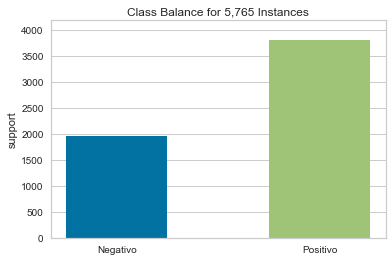

In [35]:
#analisamos uma quantidade maior de tweets positivos, pode gerar um viés ao final do modelo
visualizer = ClassBalance(labels=["Negativo",  "Positivo"])

visualizer.fit(tweets.Classificacao)        
visualizer.show()

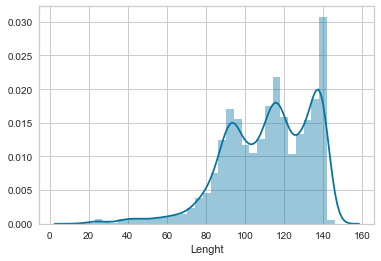

In [36]:
#plotando e analisando a distribuição da nova variavel "Lenght"
sns.distplot(tweets.Lenght)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019D9B2AE308>,
      dtype=object)

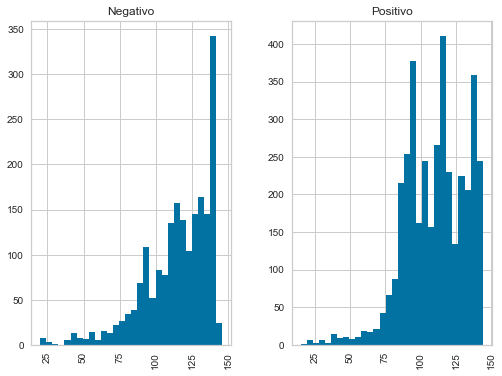

In [37]:
tweets.hist(column='Lenght', by='Classificacao', figsize=(8, 6), bins=30)

#### Preprocessamento dos tweets

In [38]:
twitter_punct = '!"$\'*+,-./?`{|}~%:'

In [39]:
#exemplo de retirada de pontuação
mensagem = 'Primeiramente: Esta frase possui a pontuação e link, viu?! https://twitter.com/'
sempont = [car for car in mensagem if car not in twitter_punct]
sempont = ''.join(sempont)
sempont

'Primeiramente Esta frase possui a pontuação e link viu httpstwittercom'

In [40]:
#remover links
re.sub('https\S+', '', mensagem)

'Primeiramente: Esta frase possui a pontuação e link, viu?! '

In [41]:
#stopwords - não agregam ao modelo
from nltk.corpus import stopwords
stopwords.words('portuguese')

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [42]:
sem_stopword = [word for word in mensagem.split() if word.lower() not in stopwords.words('portuguese')]
sem_stopword = ' '.join(sem_stopword)
sem_stopword

'Primeiramente: frase possui pontuação link, viu?! https://twitter.com/'

In [43]:
#retirar pontuações e stopwords pois não são relevantes para o modelo
def clean_text(text_list):
    #recebe uma lista de strings
    clean_text_list = []
    for text in text_list:
        
        #pontuações
        text_sempont = [char for char in text if char not in twitter_punct]
        text_sempont = ''.join(text_sempont)

        #remover links
        text_semlink = re.sub('https\S+', '', text_sempont)

        #stopwords
        text_process = [word for word in text_semlink.split() 
                        if word.lower() not in stopwords.words('portuguese')]
        text_process = ' '.join(text_process)
        
        clean_text_list.append(text_process)
        
    #retorna uma lista de strings limpa
    return clean_text_list

In [44]:
tweets['Text'] = clean_text(tweets.Text)

#### Criando um novo csv com tweets pre processados

In [45]:
#export csv with data cleaned
tweets[['Text', 'Classificacao']].to_csv('tweets_processados.csv', index=False)

#### Utilizando a biblioteca Scikit-learn para realizar processamento nos textos

In [46]:
#tokenização e vetorização
tweet_token = TweetTokenizer()
vectorizer = CountVectorizer(tokenizer=tweet_token.tokenize)

In [47]:
transformer = vectorizer.fit(tweets['Text'])

In [48]:
freq_matrix = transformer.transform(tweets['Text'])

#### Visualização das palavras que aparecem com mais frequencia nos tweets

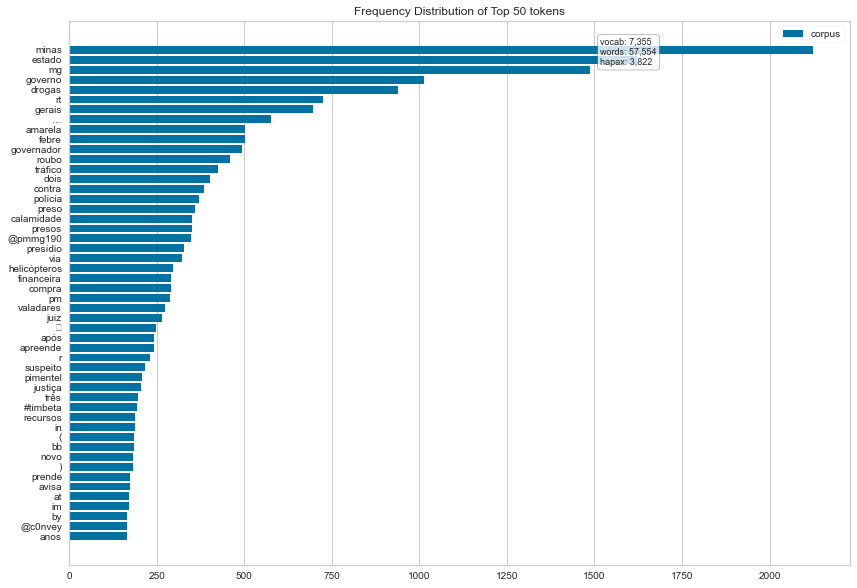

In [49]:
plt.figure(figsize=(14, 10))
feature_names = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=feature_names, orient='h')
visualizer.fit(freq_matrix)
visualizer.show()

In [50]:
#calculando o peso de cada palavra com o tf-idf
tfidf = TfidfTransformer()
tweets_tfidf = tfidf.fit_transform(freq_matrix)

In [51]:
tweets_tfidf

<5765x7355 sparse matrix of type '<class 'numpy.float64'>'
	with 56692 stored elements in Compressed Sparse Row format>

In [52]:
#fazendo o fit do modelo, utilizando Naives Bayes
nb_model = MultinomialNB()
sentiment_predictor = nb_model.fit(tweets_tfidf, tweets['Classificacao'])